In [53]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Lecture 7: Statistical Hypothesis Testing

Last update: Jan 27, 2019

In previous lectures, we talked about summary statistics that are useful for describing data, and probability theory that is a mathematical framework for random processes. Today we will talk more about the "science" part in the data science, which involves forming and testing hypotheses about our data and the processes that "generate" it.

One of the most important aspect of data science is to come up with questions and hypotheses. These hypotheses are then verified whether they are likely to be true based on the data. For example, suppose we collect outcomes of indepedent coin flips $\{H,H,T,H,T,T,T,H,H,H,H\}$, we might ask "whether the coin is fair" and form a hypothesis like "this coin is fair". A hypothesis is usually an assertion that can be translated into statistics about data. It could be something like "First-year CS students prefer Python to Java". 

A typical setup of a statistical test is as follows. First, we form a "null hypothesis" $H_0$ that represents some default position. Then, we form an alternative hypothesis $H_1$ that we'd like to compare. Next, we compute some statistics to decide whether we can "reject" the null hypothesis $H_0$ as false or not. 

Formally, a statistical test is a procedure so that we, for a given observation $x \in E$, can decide whether it is conceivable that the unknown parameter, $\theta$, is to be found in $\Theta_0$ or whether we have to use the entire parameter space $\Theta$.

This is formalized as follows. We call the hypothesis that $\theta \in \Theta_0$ the null-hypothesis
and write

$$
H_0: \theta \in \Theta_0
$$

and, the alternative hypothesis, $H_1$ is:

$$
H_1: \theta \in \Theta \backslash \Theta_0
$$



## Example: Fair Coin?

Suppose we have a coin which we are not sure whether it is a fair coin or not. We flip this coin $n$ times and collect the outcomes.

In [54]:
import random

def toss(p):
    if random.random() < p:
        return 'H'
    else: 
        return 'T'


# Case 1: The coin is actually fair
n = 100
p = 0.5
X = [ toss(p) for i in range(n) ]
X[:10]

['T', 'T', 'H', 'H', 'H', 'T', 'H', 'T', 'H', 'H']

We assume that each coin toss is a Bernoulli trial with probility $p$ of landing heads. So, our null hypothesis is "the coin is fair" -- $p = 0.5$ and we will test this against the alternative hypothesis $p \ne 0.5$

As you already know, when we flip the coin independent $n$ times, the distribution of "number of heads" is $Binomial(n,p)$ i.e. sum of Bernoulli is Binomial. 

When $n \rightarrow \infty$, $Binomial(n,p)$ can be approximated by $Normal(\mu,\sigma)$. Instead of working directly with $Binomial(n,p)$, we will use $Normal(\mu,\sigma)$ to simplify things.

So, if we believe that coin is fair, the number of heads (RV) will be distributed close to $Normal(\mu,\sigma)$ where $\mu = n*0.5$ and $\sigma = \sqrt{n*0.5(1-0.5)}$.


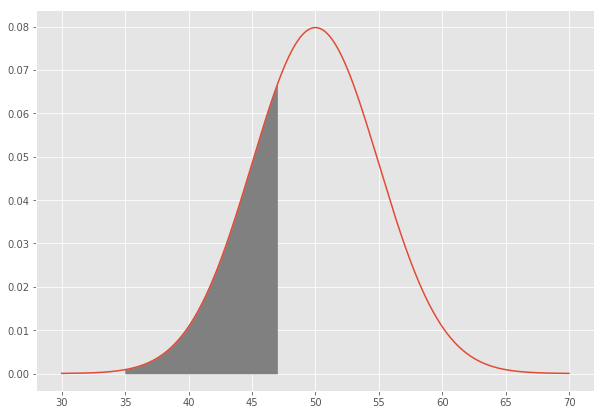

In [55]:
from scipy.stats import norm

x = np.arange(30, 70, 0.01)
mu = n*0.5
variance = n*0.5*(1-0.5)
sd = variance**0.5
plt.figure(figsize=(10,7))
y = norm.pdf(x,mu,sd)
plt.plot(x, y)

# P( 35 <'H'< 47 )
shaded_x = np.arange(35,47,0.01)
shaded_y = norm.pdf(shaded_x,mu,sd)
plt.fill_between(shaded_x,shaded_y,color='gray')

### Significance level

Next important step in hypothesis testing is to choose a **significance level**, commonly denoted by $\alpha$, which is the probability of rejecting the null hypothesis when it is actually true. The significance level is usually set to 5% or 1%. Let's go with 5% for now.

(40.200180077299734, 59.799819922700266)


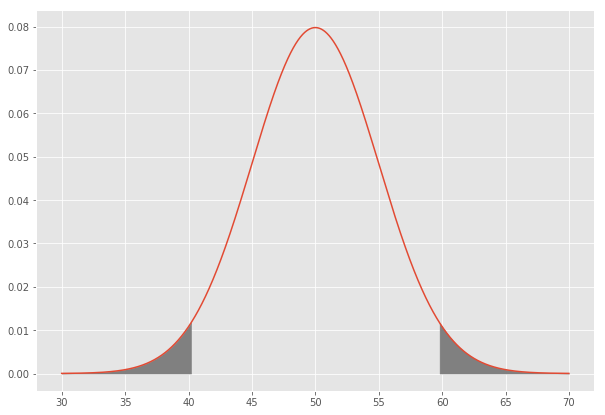

In [56]:
# Let's find out the interval that is centered at the mean and cover 95% of the AUC
alpha = 0.05
interval = norm.interval(1-alpha, mu, sd)
print(interval)

# plot again
plt.figure(figsize=(10,7))
y = norm.pdf(x,mu,sd)
plt.plot(x, y)

# alpha interval
shaded_x = np.arange(30,interval[0],0.01)
shaded_y = norm.pdf(shaded_x,mu,sd)
plt.fill_between(shaded_x,shaded_y,color='gray')

shaded_x = np.arange(interval[1],70,0.01)
shaded_y = norm.pdf(shaded_x,mu,sd)
plt.fill_between(shaded_x,shaded_y,color='gray')


According to our chosen 5% significance level, we will reject the null hypothesis $H_0$ if the number of heads in $X$ falls into the shaded region. 


To reason about this, if we assume that $p$ is really 0.5, the number of heads (RV) should distributed as shown above and there is just 5% chance that it falls into the shaded region. In other words, if $H_0$ is really true, there is only 5% that we are going to make a mistake.


In [57]:
# Number of heads in X
num_heads = len([x for x in X if x == 'H'])
print("Number of heads:", num_heads)

reject_null = not (interval[0] < num_heads < interval[1])
print("Can reject null hypothesis?", reject_null)

if reject_null:
    print("CONCLUSION: Coin is NOT fair (significance level = {})".format(alpha))
else: 
    print("CONCLUSION: Coin is fair (significance level = {})".format(alpha))

Number of heads: 58
Can reject null hypothesis? False
CONCLUSION: Coin is fair (significance level = 0.05)


### p-value

In modern reserch and scientific studies, researchers use p-value extensively in their studies. What exactly is p-value?

In short, **p-value** is the probablity that we would see a value at least as extreme as the one we actually observed assuming $H_0$ is true.

Another way to think about p-value, is area under the PDF beyond the observed value.

In [6]:
if num_heads > mu:
    p_value = 1 - norm.cdf(num_heads, mu, sd) # P(v > num_heads)
else:
    p_value = norm.cdf(num_heads, mu, sd) # P(v < num_heads)
    
print('p-value =', p_value)

p-value = 0.420740290560897


### One-sided vs Two-sided

The previous test is also known as "two-sided test" where we have $H_0$ stating that $p=0.5$ and $H_1$ stating that $p\ne0.5$.


Alternatively, we could try to perform "one-sided" version:

- H_0: $p=0.5$ (the coin is fair)
- H_1: $p>0.5$ (the coin lands on heads more often than tails)

For a significance level, $\alpha$, one-sides tests consider only either left- or right-tail of the distribution, not both.

58.22426813475736


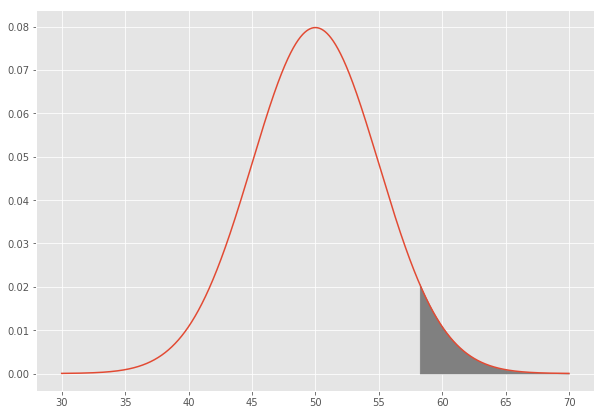

In [7]:
alpha = 0.05
threshold = norm.ppf(1-alpha, mu, sd)
print(threshold)

# plot again
plt.figure(figsize=(10,7))
y = norm.pdf(x,mu,sd)
plt.plot(x, y)

shaded_x = np.arange(threshold,70,0.01)
shaded_y = norm.pdf(shaded_x,mu,sd)
plt.fill_between(shaded_x,shaded_y,color='gray')

In [8]:
reject_null = (num_heads > threshold)
print("Can reject null hypothesis?", reject_null)

if reject_null:
    print("CONCLUSION: Coin lands on heads more often (signifance level = {})".format(alpha))
else: 
    print("CONCLUSION: Coin is fair (signifance level = {})".format(alpha))

Can reject null hypothesis? False
CONCLUSION: Coin is fair (signifance level = 0.05)


## Hypothesis testing guideline

In practice, when we do hypothesis testing. We follow the following steps:
1. Specify the null and alternative hypotheses.
2. Using the sample data and assuming the null hypothesis is true, calculate the value of the *test statistic*.
3. Using the known distribution of the test statistic, calculate the P-value: "If the null hypothesis is true, what is the probability that we'd observe a more extreme test statistic in the direction of the alternative hypothesis than we did?" (Note how this question is equivalent to the question answered in criminal trials: "If the defendant is innocent, what is the chance that we'd observe such extreme criminal evidence?")
4. Set the significance level, α, to be small — 0.01, 0.05, or 0.10. Compare the P-value to α. If the P-value is less than (or equal to) α, reject the null hypothesis in favor of the alternative hypothesis. If the P-value is greater than α, do not reject the null hypothesis.


### Test statistics

A test statistic is a random variable that is calculated from sample data and used in a hypothesis test. You can use test statistics to determine whether to reject the null hypothesis. The test statistic compares your data with what is expected under the null hypothesis. The test statistic is used to calculate the p-value.

A test statistic measures the degree of agreement between a sample of data and the null hypothesis. Its observed value changes randomly from one random sample to a different sample. A test statistic contains information about the data that is relevant for deciding whether to reject the null hypothesis. The sampling distribution of the test statistic under the null hypothesis is called the null distribution. When the data show strong evidence against the assumptions in the null hypothesis, the magnitude of the test statistic becomes too large or too small depending on the alternative hypothesis. This causes the test's p-value to become small enough to reject the null hypothesis.

For example, the test statistic for a Z-test is the Z-statistic, which has the standard normal distribution under the null hypothesis. Suppose you perform a two-tailed Z-test with an α of 0.05, and obtain a Z-statistic (also called a Z-value) based on your data of 2.5. This Z-value corresponds to a p-value of 0.0124. Because this p-value is less than α, you declare statistical significance and reject the null hypothesis.

Different hypothesis tests use different test statistics based on the probability model assumed in the null hypothesis. Common tests and their test statistics include:

| Hypothesis test	| Test statistic |
|-------------------|----------------|
| Z-test	| Z-statistic |
| t-tests	| t-statistic |
| ANOVA	| F-statistic |
| Chi-square tests	| Chi-square statistic |


### Example: Quiz scores (t-test)

We believe that quiz scores of a class distributed normally with $\mu = 50$. Given an observed scores, perform a hypothesis testing to determine whether the mean is really 50.

In [3]:
scores = np.array([46.85305221, 26.1675956 , 43.95835927, 63.14016061, 83.64057177, 
                35.47509908, 60.86484489, 53.73799298, 92.38937915, 55.74113059,
                59.24882812, 48.35935207, 73.77349993, 53.10609059, 36.48630154, 
                53.14600263, 54.00135143, 60.63089924, 95.51964724, 73.66544803, 
                66.37856748, 68.18856184, 32.42389482, 62.27084733, 61.51821799,
                36.85036105, 32.35595856, 76.17190358, 57.29816995, 60.25821504, 
                86.55732566, 57.09009663, 48.04988424, 52.77233494, 94.30381766, 
                69.08847148, 52.93718782, 59.99637199, 56.91433885, 77.53143737,       
                58.17739352, 58.34612257, 55.75442827, 76.83333842, 54.59777636, 
                36.47049618, 94.87000232, 45.75892031, 90.5429917 , 36.67837733])


### State your hypotheses

$H_0$: $\mu_R = 50$

$H_1$: $\mu_R \ne 50$



To test this hypothesis, we will use "one-sample t-test"

In [74]:
from scipy.stats import ttest_1samp, ttest_rel, ttest_ind, normaltest

# two-sided by default
print(ttest_1samp(scores, 50))

Ttest_1sampResult(statistic=array([-4.792542  , -4.24360132]), pvalue=array([0.00073179, 0.00170668]))


From the test, we have p-value < 0.05. Hence, we can **reject** the null hypothesis.

<div class="alert alert-block alert-success">
    <b>Your Task: Height of Sunflowers </b>
A biologist was interested in determining whether sunflower seedlings treated with an extract from Vinca minor roots resulted in a lower average height of sunflower seedlings than the standard height of 15.7 cm. The biologist treated a random sample of n = 33 seedlings with the extract and subsequently obtained the following heights:
</div>

In [103]:
heights = [
    11.5,11.8,15.7,16.1,14.1,10.5,9.3,15.0,11.1,
    15.2,19.0,12.8,12.4,19.2,13.5,12.2,13.3, 
    16.5,13.5,14.4,16.7,10.9,13.0,10.3,15.8, 
    15.1,17.1,13.3,12.4,8.5,14.3,12.9,13.5] 

### State your hypothesis

- $H_0$: $\mu_R = 15.7$ (normal avg flower height)

- $H_1$: $\mu_R < 15.7$ (lowering the flower height)

In [104]:
# Perform one-sided one-sample t-test
# HINT: you can still use ttest_1samp()

print(ttest_1samp(heights, 15.7))

Ttest_1sampResult(statistic=-4.599006005602887, pvalue=6.348487914001979e-05)


In [105]:
heights = np.sort(heights)

In [106]:
mu = np.mean(heights)
sd = np.std(heights)

(8.754394413589353, 18.572878313683375)


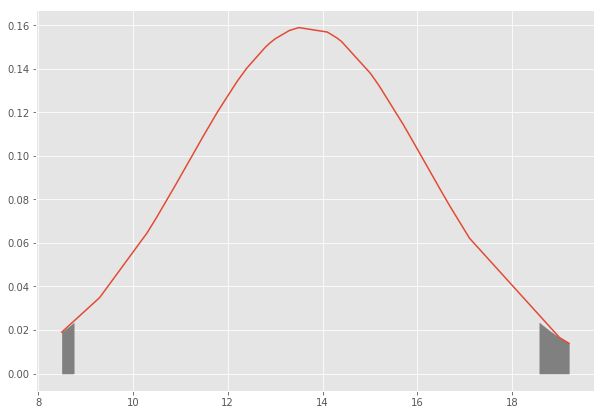

In [107]:
# Let's find out the interval that is centered at the mean and cover 95% of the AUC
alpha = 0.05
interval = norm.interval(1-alpha, mu, sd)
print(interval)

# plot again
plt.figure(figsize=(10,7))
y = norm.pdf(heights,mu,sd)
plt.plot(heights, y)

# alpha interval
shaded_x = np.arange(heights[0],interval[0],0.01)
shaded_y = norm.pdf(shaded_x,mu,sd)
plt.fill_between(shaded_x,shaded_y,color='gray')

shaded_x = np.arange(interval[1],heights[-1],0.01)
shaded_y = norm.pdf(shaded_x,mu,sd)
plt.fill_between(shaded_x,shaded_y,color='gray')


In [108]:
heights = np.linspace(heights[0] * 0.5, heights[-1] * 1.2, 100)

(8.754394413589353, 18.572878313683375)


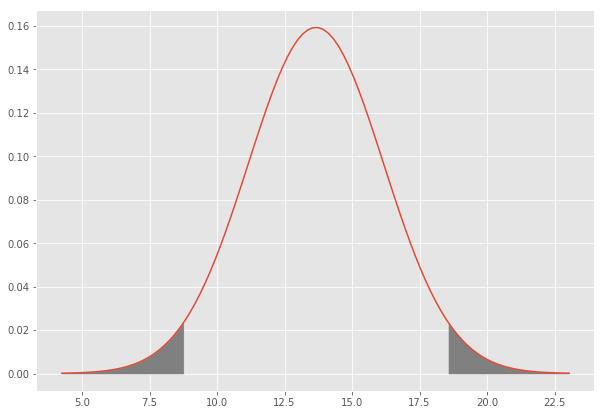

In [109]:
# Let's find out the interval that is centered at the mean and cover 95% of the AUC
alpha = 0.05
interval = norm.interval(1-alpha, mu, sd)
print(interval)

# plot again
plt.figure(figsize=(10,7))
y = norm.pdf(heights,mu,sd)
plt.plot(heights, y)

# alpha interval
shaded_x = np.arange(heights[0],interval[0],0.01)
shaded_y = norm.pdf(shaded_x,mu,sd)
plt.fill_between(shaded_x,shaded_y,color='gray')

shaded_x = np.arange(interval[1],heights[-1],0.01)
shaded_y = norm.pdf(shaded_x,mu,sd)
plt.fill_between(shaded_x,shaded_y,color='gray')


### State your conclusion

<div class="alert alert-block alert-success">
  <b>Your Task: Teaching Evaluation</b> A teacher is trying to determine whether students have improved before and after his teaching. Here are the students' scores:
</div>

In [63]:
# (before, after)
scores = np.array([
    (19,22),
    (26,25),
    (32,36),
    (24,32),
    (49,49),
    (42,46),
    (23,31),
    (53,52),
    (26,30),
    (39,42),
    (38,44)])

### State your hypothesis

- $H_0: \mu_{before} = \mu_{after}$

- $H_1: \mu_{before} \ne \mu_{after}$

In [69]:
# Checkout out ttest_rel()
print(ttest_rel(scores[:, 0], scores[:, 1]))

Ttest_relResult(statistic=-3.6100541512184057, pvalue=0.0047676769007037705)


### State your conclusion

<div class="alert alert-block alert-success">
  <b>Your Task: Teaching Evaluation (Again)</b> A teacher is teaching two sections. He's trying to determine whether students from one section is any better than another section.
</div>

In [71]:
section1 = [66.73181413018435, 72.34781959216814, 82.81281092111428, 85.302756300001, 76.60265743703683, 73.71493236840955, 71.00862208214622, 83.80075525961186, 75.70178871797536, 89.10113324964188, 79.98801223539078, 68.94738567344827, 86.68422258279321, 77.9228740100482, 72.23098047291438, 68.20056010934172, 80.27767666615648, 86.0087034749179, 81.76310668478597, 84.3250442635123, 94.47653473847244, 86.39960006757421, 75.70004400988884, 83.82490515435136, 66.39399253995862, 74.9287360500244, 88.93408337280434, 69.60312619095691, 88.84465486550141, 76.54334003261455]
section2 = [66.53772374128279, 87.21041863159333, 84.50543375709013, 69.0971313456738, 69.40694803534282, 80.38223595666314, 81.80758767029867, 85.8209311495314, 88.09122178658701, 71.6139670260851, 76.61974173545491, 64.92823503456047, 78.1055609007175, 68.78465266104801, 88.77865507432254, 87.22157878796556, 64.75649238653646, 74.93588453017624, 61.796216350443935, 65.48260736406938, 83.03821405813717, 65.04895213792253, 61.36035394432241, 75.99279769090847, 78.22997086212371, 88.80304525459626, 79.38130033341838, 65.61789150881347, 79.66064597508242, 89.55399363548264]

### State your hypothesis

- $H_0: \mu_{section1} = \mu_{section2}$

- $H_1: \mu_{section1} \ne \mu_{section2}$

In [72]:
# Checkout out ttest_ind()

print(ttest_ind(section1, section2))

Ttest_indResult(statistic=1.3195930805083427, pvalue=0.19215619938004036)


### State your conclusion

<div class="alert alert-block alert-success">
  <b>Your Task: Is it normal?</b> Suppose you collect height data from your friends. Perform a test to check wheter the data is normally distributed. Read more here <a href="https://en.wikipedia.org/wiki/Normality_test">https://en.wikipedia.org/wiki/Normality_test</a>
</div>

In [75]:
data = [169, 157, 163, 173, 152, 165, 163, 154, 170, 166, 157, 172, 
        166, 150, 152, 171, 167, 161, 160, 166, 167, 174, 164, 150, 
        152, 160, 154, 167, 159, 151, 159, 151, 158, 166, 162, 163, 
        158, 153, 170, 160, 174, 165, 152, 163, 167, 165, 151, 173, 171, 160]

### State your hypothesis

- $H_0$

- $H_1$

In [76]:
# check out normaltest

### State your conclusion

In [77]:
normaltest(data)

NormaltestResult(statistic=7.300201663275303, pvalue=0.025988508182797892)

### Common misunderstandings of p-values

From: https://en.wikipedia.org/wiki/Misunderstandings_of_p-values


1. **The p-value is not the probability that the null hypothesis is true, or the probability that the alternative hypothesis is false.** A p-value can indicate the degree of compatibility between a dataset and a particular hypothetical explanation (such as a null hypothesis). Specifically, the p-value can be taken as the prior probability of an observed effect given that the null hypothesis is true—which should not be confused with the posterior probability that the null hypothesis is true given the observed effect (see prosecutor's fallacy). In fact, frequentist statistics does not attach probabilities to hypotheses.
2. **The p-value is not the probability that the observed effects were produced by random chance alone.** The p-value is computed under the assumption that a certain model, usually the null hypothesis, is true. This means that the p-value is a statement about the relation of the data to that hypothesis.
3. **The 0.05 significance level is merely a convention.** The 0.05 significance level (alpha level) is often used as the boundary between a statistically significant and a statistically non-significant p-value. However, this does not imply that there is generally a scientific reason to consider results on opposite sides of any threshold as qualitatively different, and the common choice of 0.05 as the threshold is only a convention.
4. **The p-value does not indicate the size or importance of the observed effect.** A small p-value can be observed for an effect that is not meaningful or important. In fact, the larger the sample size, the smaller the minimum effect needed to produce a statistically significant p-value (see effect size).
